In [80]:
import torch
import torch.nn as nn
from glob import glob
import matplotlib.pyplot as plt

In [81]:
# !unzip '/content/drive/MyDrive/XRAY/흉부선 X-ray.zip'

In [82]:
print(len(glob('/content/chest_xray/train/*/*')))
print(len(glob('/content/chest_xray/test/*/*')))
print(len(glob('/content/chest_xray/val/*/*')))

5216
624
16


In [83]:
# 정상흉부이미지개수(NORMAL), 폐렴흉부 이미지 개수(PNEUMONIA)

In [84]:
len(glob('/content/chest_xray/train/NORMAL/*')),len(glob('/content/chest_xray/test/NORMAL/*')),len(glob('/content/chest_xray/val/NORMAL/*'))

(1341, 234, 8)

In [85]:
len(glob('/content/chest_xray/train/PNEUMONIA/*')),len(glob('/content/chest_xray/test/PNEUMONIA/*')),len(glob('/content/chest_xray/val/PNEUMONIA/*'))

(3875, 390, 8)

In [86]:
1341+ 234+ 8, 3875+ 390+ 8

(1583, 4273)

In [87]:
1583 / (1583+ 4273),  4273 / (1583+ 4273)

(0.2703210382513661, 0.7296789617486339)

In [88]:
import cv2

In [89]:
train_normal = glob('/content/chest_xray/train/NORMAL/*')[:3]
train_PNEUMONIA = glob('/content/chest_xray/train/PNEUMONIA/*')[:3]

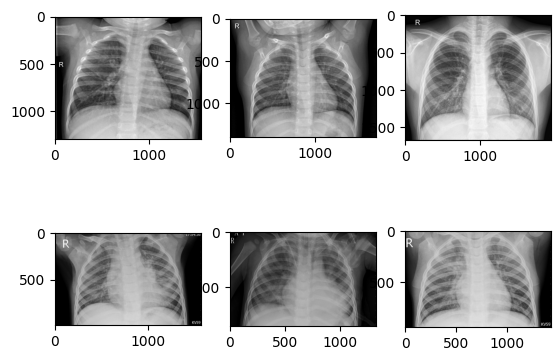

In [90]:
for  idx,fname in enumerate( train_normal):
  normal_img = cv2.imread(fname)
  pneumonia_img = cv2.imread(train_PNEUMONIA[idx])
  plt.subplot(2,3,idx+1)
  plt.imshow(normal_img)

  plt.subplot(2,3,idx+4)
  plt.imshow(pneumonia_img)

plt.show()

- 베이스라인
  - 데이터 증강
  - 전이학습(efficientnet-b0)
  - 옵티마이져 : Adam
- 성능개선
  - 데이터 증강:동일
  - 신경망: efficientnet-b1+efficientnet-b2+efficientnet-b3 앙상블
  - 옵티마이져 : AdamW

시드값 고정

In [91]:
import pandas as pd
import numpy as np
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [92]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

이미지 변환기

In [93]:
from torchvision import transforms
transform_train = transforms.Compose(
    [
        transforms.Resize((250,250)),
        transforms.CenterCrop(180),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.2),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4,0.4,0.4),std=(0.2,0.2,0.2))
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Resize((250,250)),
        transforms.CenterCrop(180),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4,0.4,0.4),std=(0.2,0.2,0.2))
    ]
)

In [94]:
# 0 : Normal  /    1 :  Pneumonia

데이터 셋

In [95]:
from torchvision.datasets import ImageFolder

In [96]:
dataset_train = ImageFolder(root='/content/chest_xray/train/', transform=transform_train)
dataset_test = ImageFolder(root='/content/chest_xray/test/', transform=transform_test)
dataset_valid = ImageFolder(root='/content/chest_xray/val/', transform=transform_test)

데이터 로더

In [97]:
from torch.utils.data import DataLoader
batch_size=8
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size,
                          shuffle=True,num_workers=2)
loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size,
                          shuffle=False,num_workers=2)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=batch_size,
                          shuffle=False,num_workers=2)

In [98]:
imgdata,label =  next(iter(loader_train))
np.array(imgdata).shape

(8, 3, 180, 180)

사전훈련된 모델 가져오기

In [99]:
!pip install efficientnet-pytorch

In [100]:
from efficientnet_pytorch import EfficientNet

In [101]:
model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=2)
model.to(device)

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

손실함수 및 옵티마이져

In [102]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [103]:
from sklearn.metrics import accuracy_score,recall_score,f1_score

훈련 : 함수로..

In [104]:
from tqdm import tqdm
def train(model,loder_train,loder_valid,criterion,optimizer
          ,scheduler=None,epochs=10,save_file='model_state_dic.pth'):
  valid_loss_min = np.inf # 가장 큰 무한대의 값으로 초기화
  for epoch in range(epochs):
    iterdata = tqdm(loader_train)
    model.train() # 훈련상태로 변경. Efficient에 내장
    epoch_train_loss = 0
    #[훈련]
    for images, labels in iterdata:
      # 데이터 장비로 이동
      images = images.to(device); labels = labels.to(device)
      # 기울기 초기화
      optimizer.zero_grad()
      # 순전파
      output = model(images)
      # 손실값계산
      loss = criterion(output,labels)
      epoch_train_loss += loss.item()
      # 역전파
      loss.backward()
      # 가중치 갱신
      optimizer.step()
      # 학습률 갱신(스케줄러가 있으면)
      if scheduler:
        scheduler.step()
      # iterdata.set_description() 진행상황 출력
      iterdata.set_description(f"epoch:{epoch+1}, loss:{loss.item()}")

    #[검증]
    model.eval()
    epoch_val_loss = 0
    preds_list,true_list = [],[]  # 예측값, 실제값
    iterdata_val = tqdm(loder_valid)
    for images, labels in iterdata_val:
      # 데이터 장비로 이동
      images = images.to(device); labels = labels.to(device)
      # 순전파
      outputs = model(images)
      # 손실값계산
      loss = criterion(outputs,labels)
      epoch_val_loss += loss.item()
      preds = torch.max(outputs.cpu(), dim=1)[1].numpy()  # 0:데이터  1:클래스별 확률
      true = labels.cpu().numpy()

      preds_list.extend(preds)
      true_list.extend(true)
    #평가지표
    val_accuracy = accuracy_score(true_list,preds_list)
    val_recall = recall_score(true_list,preds_list)
    val_f1_score = f1_score(true_list,preds_list)
    print(f"정확도:{val_accuracy:.4f} 재현율:{val_recall:.4f} F1:{val_f1_score:.4f}")
    #[최적의 가중치 찾기] - early stopping과 비슷한 느낌
    # 현재 손실값이 지금까지의 손실값보다 가장작으면
    if epoch_val_loss <= valid_loss_min:
      torch.save(model.state_dict(),save_file)  # 저장
      valid_loss_min = epoch_val_loss
    # 현재 모델의 가중치 저장
  return torch.load(save_file) # 최적의 모델 가중치를 반환

모델 훈련

In [106]:
model_state_dic = train(model = model,
                        loder_train=loader_train,
                        loder_valid = loader_valid,
                        criterion=criterion,
                        optimizer=optimizer
                        )

100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


정확도:0.6250 재현율:1.0000 F1:0.7273


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


정확도:0.6875 재현율:0.5000 F1:0.6154


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


정확도:0.5000 재현율:1.0000 F1:0.6667


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


정확도:0.4375 재현율:0.6250 F1:0.5263


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


정확도:0.5000 재현율:1.0000 F1:0.6667


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


정확도:0.6250 재현율:0.2500 F1:0.4000


100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


정확도:0.7500 재현율:0.8750 F1:0.7778


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


정확도:0.5000 재현율:1.0000 F1:0.6667


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


정확도:0.6250 재현율:1.0000 F1:0.7273


100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

정확도:0.6250 재현율:1.0000 F1:0.7273


예측

In [107]:
def predict(model,loader_test):
  model.eval()
  preds_list,true_list = [],[]
  with torch.no_grad():
    for images,labels in loader_test:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      preds =  torch.max(outputs.cpu(),dim=1)[1].numpy()
      true = labels.cpu().numpy()
      preds_list.extend(preds)
      true_list.extend(true)
  return preds_list,true_list

In [109]:
#모델 불러오기
model.load_state_dict(model_state_dic)
pred_list, true_list = predict(model,loader_test=loader_test)

In [110]:
val_accuracy = accuracy_score(true_list,pred_list)
val_recall = recall_score(true_list,pred_list)
val_f1_score = f1_score(true_list,pred_list)
print(f"정확도:{val_accuracy:.4f} 재현율:{val_recall:.4f} F1:{val_f1_score:.4f}")

정확도:0.7981 재현율:0.7308 F1:0.8190


In [ ]:
pred_list

개선사항
  - 스케줄러 사용 : 학습률을 크게->작게 변화량을 줌
  - effici~~b0, b1, b3 각각모델학습하고 결과를 취합
  - 1의 갯수를 더하고 / 3 = np.round()를 이용해서 반올림


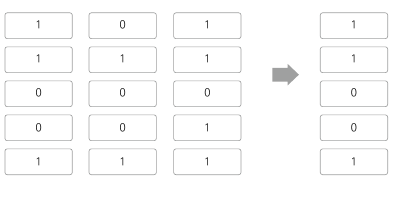